In [2]:
import numpy as np
import tensorflow as tf
tf.enable_eager_execution()
tf.__version__

'1.14.0'

## Load local Images

In [3]:
import pathlib

img_path = "/home/Data/CharactersTrimPad28/"
img_path = "/home/Data/ChineseNumbers/"
data_root = pathlib.Path(img_path)
print(data_root)

/home/Data/ChineseNumbers


In [4]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

image_count = len(all_image_paths)
image_count

12607

In [5]:
all_image_paths[:10]

['/home/Data/ChineseNumbers/二/Han yi Cu yuan ti Font-Traditional Chinese ttf.png',
 '/home/Data/ChineseNumbers/二/JiaShang Liu Xing kai 5500 Font- Simplified Chinesettf.png',
 '/home/Data/ChineseNumbers/二/Japan hengshan writing brush Font-Traditional Chinesettf.png',
 '/home/Data/ChineseNumbers/二/Classic Cu hei Fontttf.png',
 '/home/Data/ChineseNumbers/二/Chinese New Year(DFGirl-dospy-fei) font-Simplified Chinesettf.png',
 '/home/Data/ChineseNumbers/二/Han yi Fang die Fontttf.png',
 '/home/Data/ChineseNumbers/二/Classic Kong die hei Fontttf.png',
 '/home/Data/ChineseNumbers/二/Childhood amusement park Font-Simplified Chinesettf.png',
 '/home/Data/ChineseNumbers/二/Snow World  Butterfly Font-Simplified Chinesettf.png',
 '/home/Data/ChineseNumbers/二/Hypocrite Youth v 20 Font-Simplified ChineseTTF.png']

## Determine the label

In [6]:
char_list = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
char_list

['一', '七', '三', '九', '二', '五', '八', '六', '十', '四']

In [7]:
char_to_label = dict((char, index) for index, char in enumerate(char_list))
char_to_label

{'一': 0,
 '七': 1,
 '三': 2,
 '九': 3,
 '二': 4,
 '五': 5,
 '八': 6,
 '六': 7,
 '十': 8,
 '四': 9}

## Inspect the images and labels

In [8]:
import IPython.display as display
import random

random.shuffle(all_image_paths)
all_image_labels = [char_to_label[pathlib.Path(path).parent.name]
                    for path in all_image_paths]
label_to_char = dict((label, char) for char, label in char_to_label.items())

for n in range(3):
  image_path = all_image_paths[n]
  display.display(display.Image(image_path))

  label = all_image_labels[n]
  char = label_to_char[label]
    
  print("char:", char, ", label:", label)
  print(image_path)

char: 八 , label: 6
/home/Data/ChineseNumbers/八/Zao Zi Gong Fang  Elegant Art Chinese Font(Normal Font) -Simplified Chinesettf.png


char: 七 , label: 1
/home/Data/ChineseNumbers/七/Fang zheng Cu yuan Font-Simplified Chinesettf.png


char: 九 , label: 3
/home/Data/ChineseNumbers/九/Han yi Water waves Font-Simplified Chinesettf.png


## Load and format the images

In [9]:
img_path = all_image_paths[0]
img_raw = tf.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1...


In [10]:
img_tensor = tf.image.decode_image(img_raw, channels=3)
print(img_tensor.shape)
print(img_tensor.dtype)

(28, 28, 3)
<dtype: 'uint8'>


In [11]:
img_tensor = tf.cast(img_tensor, tf.float32)
img_tensor /= 255.0
print(img_tensor.shape)
print(img_tensor.dtype)

(28, 28, 3)
<dtype: 'float32'>


In [12]:
def preprocess_image(image):
  image = tf.image.decode_image(image, channels=3)
  image = tf.cast(image, tf.float32)
  image /= 255.0  # normalize to [0,1] range
  return image

In [13]:
def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

In [14]:
import matplotlib.pyplot as plt

rand_idx = random.randint(1, len(all_image_paths))
image_path = all_image_paths[rand_idx]
label = all_image_labels[rand_idx]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
print(image_path)
print(label, label_to_char[label])

/home/Data/ChineseNumbers/十/Qing niao Super bold face letter Font-Simplified Chinesettf.png
8 十


## Build a `tf.data.Dataset`

- path dataset

In [26]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
path_ds

<DatasetV1Adapter shapes: (), types: tf.string>

- image dataset

In [22]:
image_ds = path_ds.map(load_and_preprocess_image)
image_ds

<DatasetV1Adapter shapes: <unknown>, types: tf.float32>

- index dataset

In [23]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))
label_ds

<DatasetV1Adapter shapes: (), types: tf.int64>

## A dataset of (image, label) pairs

In [62]:
import matplotlib.pyplot as plt
import random

def show_items(image_label_ds, n=1):
    for image, label in image_label_ds.take(n):
        char = label_to_char[label.numpy()]
        
    plt.imshow(image)
    print("character: {}".format(char))

### Method 1: zip two dataset

character: 八


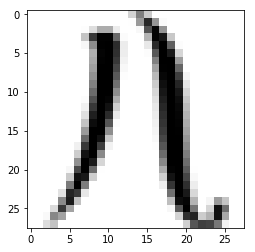

In [63]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

show_items(image_label_ds)

### Method 2: create from two arrays

character: 七


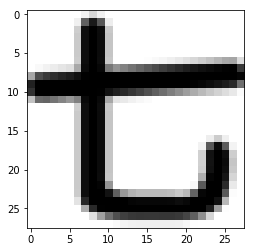

In [64]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

AUTOTUNE = tf.data.experimental.AUTOTUNE
image_label_ds = ds.map(load_and_preprocess_from_path_label, num_parallel_calls=AUTOTUNE)

show_items(image_label_ds)